# 『Machine learning phases of matter』を理解したい
## 原著論文について

https://arxiv.org/abs/1605.01735

### Abstract

Neural networks can be used to identify phases and phase transitions in condensed matter systems via supervised machine learning.

Readily programmable through modern software libraries, we show that a standard feed-forward neural network can be trained to detect multiple types of order parameter directly from raw state configurations sampled with Monte Carlo. 

In addition, they can detect highly non-trivial states such as Coulomb phases, and if modified to a convolutional neural network, topological phases with no conventional order parameter. 

We show that this classification occurs within the neural network without knowledge of the Hamiltonian or even the general locality of interactions. 

These results demonstrate the power of machine learning as a basic research tool in the field of condensed matter and statistical physics.


ニューラルネットワークは、教師ありの機械学習によって、凝縮系における相や相転移を特定するために使用することができます。

最新のソフトウェアライブラリで容易にプログラム可能です、 

標準的なフィードフォワードニューラルネットワークを学習させることで、モンテカルロ法でサンプリングした生の状態構成から直接、複数種類のオーダーパラメータを検出できることを示すものです。

また、畳み込みニューラルネットワークに変更することで、従来の秩序変数のないトポロジカル相を検出することができます。

この分類は、ハミルトニアンや相互作用の一般的な局所性さえも知ることなく、ニューラルネットワーク内で行われることを示す。これらの結果は、物性物理学および統計物理学の分野における基礎研究ツールとして、機械学習の威力を示すものである。


## 1回目(6/7)：導入
簡単な平衡統計物理学の理解をしましょう．

### 調和振動
OUノイズは，調和振動子ポテンシャルに従うブラウン運動である．

チャップマン・コロモゴロフ方程式
$$
\frac{\partial p(x , t)}{\partial t} =  \frac{\partial (k x p(x , t))}{\partial x} +\frac{D}{2} \frac{\partial^2 p(x , t)}{\partial x^2}
$$

確率微分方程式
$$
dx = -kx\ dt+ \sqrt{D}\ dW(t)
$$

積分方程式
$$
x(t) = x(0) \exp{\{-kt\}} + \sqrt{D} \int_0^t \exp{\{-k(t-s)\}} dW(s)
$$

理論的な期待値
$$
E[x(t)] = x_0 \exp{\{-kt\}}
$$

理論的な分散
$$
Var[x(t)] = \frac{D}{2k} (1 - \exp{\{-2kt\}})
$$

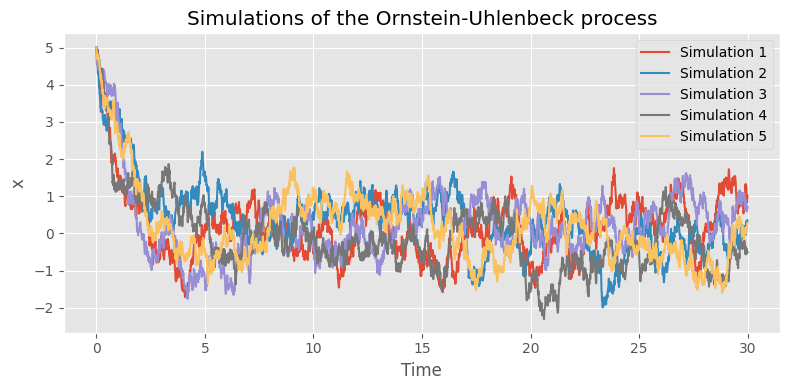

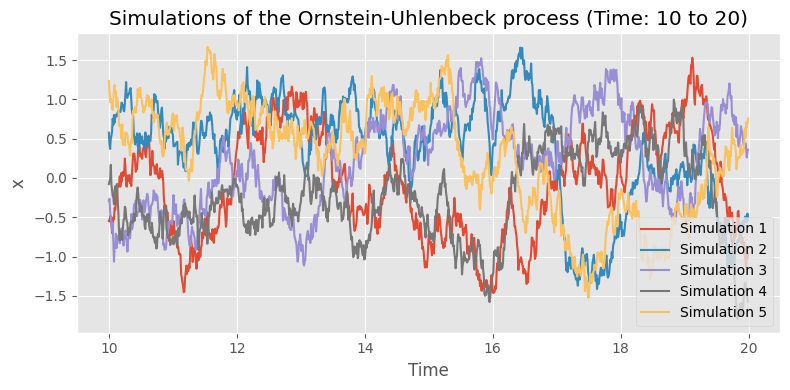

In [23]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# k = 1.0e-23# ボルツマン定数 

# パラメータの設定
k = 1.0  # ボルツマン定数 k
D = 1.0  # 温度のパラメータ D
dt = 0.01  # 時間刻み幅
T = 30.0  # シミュレーション時間
N = int(T / dt)  # シミュレーションのステップ数

# 初期条件
x0 = 5.0  # 初期値 x(0)
t = np.zeros(N)  # 時間の配列

# シミュレーションの繰り返し
num_simulations = 5  # シミュレーション回数
simulations = np.zeros((num_simulations, N))  # シミュレーション結果の配列

for i in range(num_simulations):
    x = np.zeros(N)  # xの値の配列
    x[0] = x0
    
    for j in range(N-1):
        dW = np.random.normal(0, np.sqrt(dt))  # Wiener過程の増分
        x[j+1] = x[j] - k * x[j] * dt + np.sqrt(D) * dW
        t[j+1] = t[j] + dt
    
    simulations[i] = x

# 元の0から観測時間までのプロット
plt.figure(figsize=(8, 4))
for i in range(num_simulations):
    plt.plot(t, simulations[i], label=f'Simulation {i+1}')
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Simulations of the Ornstein-Uhlenbeck process')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 時間範囲の指定
t_start = 10.0
t_end = 20.0
start_index = int(t_start / dt)
end_index = int(t_end / dt)

# 時間指定したプロット
plt.figure(figsize=(8, 4))
for i in range(num_simulations):
    plt.plot(t[start_index:end_index], simulations[i, start_index:end_index], label=f'Simulation {i+1}')
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Simulations of the Ornstein-Uhlenbeck process (Time: 10 to 20)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

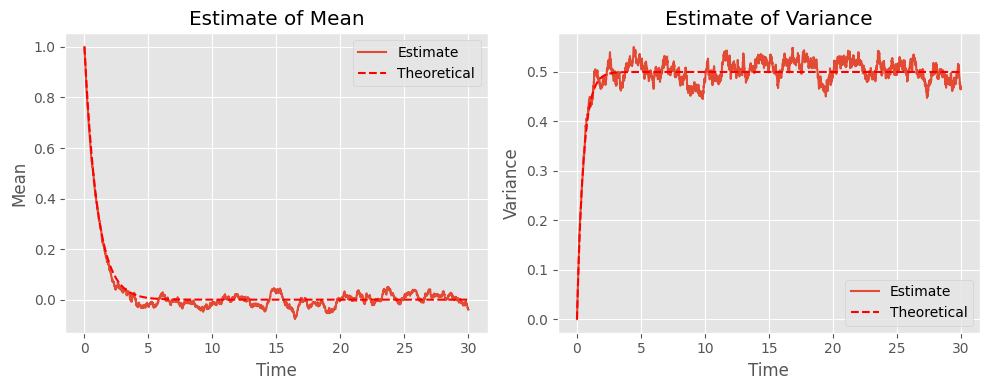

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# パラメータの設定
k = 1.0  # ボルツマン定数 k
D = 1.0  # 熱浴の温度定数 D
dt = 0.01  # 時間刻み幅
T = 30.0  # シミュレーション時間
N = int(T / dt)  # シミュレーションのステップ数

# 初期条件
x0 = 1.0  # 初期値 x(0)
t = np.zeros(N)  # 時間の配列

# シミュレーションの繰り返し
num_simulations = 1000  # シミュレーション回数
simulations = np.zeros((num_simulations, N))  # シミュレーション結果の配列

for i in range(num_simulations):
    x = np.zeros(N)  # xの値の配列
    x[0] = x0
    
    for j in range(N-1):
        dW = np.random.normal(0, np.sqrt(dt))  # Wiener過程の増分
        x[j+1] = x[j] - k * x[j] * dt + np.sqrt(D) * dW
        t[j+1] = t[j] + dt
    
    simulations[i] = x

# 期待値と分散の推定値の計算
mean_estimates = np.mean(simulations, axis=0)
variance_estimates = np.var(simulations, axis=0)

# 理論的な期待値と分散の計算
x_theoretical = x0 * np.exp(-k * t)
mean_theoretical = x0 * np.exp(-k * t)
variance_theoretical = (D / (2 * k)) * (1 - np.exp(-2 * k * t))

# グラフのプロット
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(t, mean_estimates, label='Estimate')
plt.plot(t, mean_theoretical, 'r--', label='Theoretical')
plt.xlabel('Time')
plt.ylabel('Mean')
plt.title('Estimate of Mean')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, variance_estimates, label='Estimate')
plt.plot(t, variance_theoretical, 'r--', label='Theoretical')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.title('Estimate of Variance')
plt.legend()

plt.tight_layout()
plt.show()

### 2粒子系

ハミルトニアンが与えられたとき，その系の状態は以下のようなボルツマン分布に従います．
$$
P[C] = \frac{1}{Z} e^{-\beta E[C]}
$$

具体的にハミルトニアンを以下のように設定します．$s_i = \{ -1 , + 1 \}$として
$$
E[C] = -J s_1 s_2 -h (s_1 + s_2)
$$

$h$は外部磁場，$J$ は相互作用の強さを表します．

$s_1 , s_2$の組み合わせは$2^2$通りあり，それぞれにボルツマン分布に従った確率が定義されます．
$$
P[C] = \frac{1}{Z} e^{-\beta \{ -J s_1 s_2 -h (s_1 + s_2)\}}
$$

ここで知りたいのは，『磁石としての強さ』です．
$$
m[C] = \frac{1}{2} \sum_i s_i
$$

この磁化率も確率変数です．

期待値は
$$
\langle m \rangle = \sum_C m[C] P[C]
$$

これを計算すると
$$
\langle m \rangle = \frac{1}{Z} \sum_C m[C] e^{-\beta E[C]}
$$

となります．

以上のことを実際に実装してみましょう．

In [25]:
import numpy as np

#k = 1.380649 * 10**(-23) # Boltzmann constant

$$
E[C] = -J s_1 s_2 -h (s_1 + s_2)
$$

In [26]:
# ハミルトニアンの定義
def test_hamiltonian(J , h , s):
    s1 = s[0]
    s2 = s[1]
    return -J * s1 * s2 - h * (s1 + s2)

$$
P[C] = \frac{1}{Z} e^{-\beta \{ -J s_1 s_2 -h (s_1 + s_2)\}}
$$

In [27]:
# ボルツマン分布（分子）の定義
def test_boltzmann(J , h , s , T):
    k = 1
    s1 = s[0]
    s2 = s[1]
    beta = 1 / (k * T)
    return np.exp(-beta * test_hamiltonian(J , h , s) )

In [28]:
# 分配関数の定義
def test_partition(J , h , T):
    k = 1
    beta = 1 / (k * T) 
    return np.exp(beta * (J + 2 * h)) + np.exp(beta * (J - 2 * h)) + 2 * np.exp(-beta * J)

In [29]:
# ボルツマン分布の定義
def test_boltzmann_factor(J , h , s , T):
    return test_boltzmann(J , h , s , T) / test_partition(J , h , T)

In [30]:
# すべての配列を定義
s1 = np.array([1 , 1])
s2 = np.array([1 , -1])
s3 = np.array([-1 , 1])
s4 = np.array([-1 , -1])

In [31]:
# パラメータ
J = 1
h = 0.5
T = 1

test_boltzmann_factor(J , h , s1 , T) , test_boltzmann_factor(J , h , s2 , T) , test_boltzmann_factor(J , h , s3 , T) , test_boltzmann_factor(J , h , s4 , T)

(0.809775991523652,
 0.04031637265264287,
 0.04031637265264287,
 0.10959126317106233)

In [32]:
# すべての可能性の和
test_boltzmann_factor(J , h , s1 , T) + test_boltzmann_factor(J , h , s2 , T) + test_boltzmann_factor(J , h , s3 , T)  + test_boltzmann_factor(J , h , s4 , T)

1.0

$$
m[C] = \frac{1}{2} \sum_i s_i
$$


In [33]:
# 磁化率の定義
def test_magnetization(s):
    return np.sum(s) / len(s)

In [34]:
test_magnetization(s1) , test_magnetization(s2) , test_magnetization(s3) , test_magnetization(s4)

(1.0, 0.0, 0.0, -1.0)

$$
\langle m \rangle = \sum_C m[C] P[C]
$$
つまり
$$
\langle m \rangle = \frac{1}{Z} \{ \exp(\beta(J+2h)) - \exp(\beta(J-2h)) \}
$$

In [35]:
# 磁化率の期待値
def test_magnetization_expectation(J , h , T):
    beta = 1 / T
    return (np.exp(beta *(J + 2*h)) - np.exp(beta * (J - 2*h)) ) / test_partition(J , h , T)

In [36]:
test_magnetization_expectation(J , h , T)

0.7001847283525897

磁化率の期待値に対して，パラメータを変化させたときの推移をグラフ化しましょう．

In [37]:
import matplotlib.pyplot as plt

温度を変えてみる

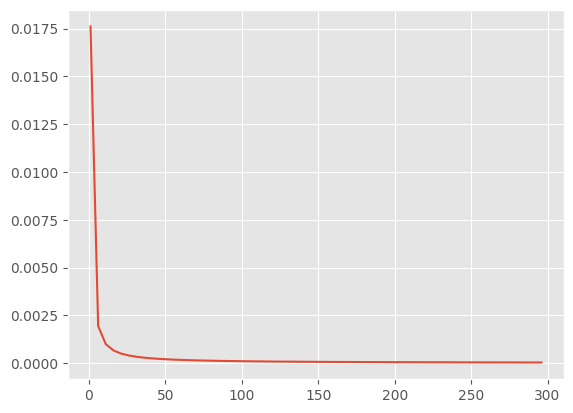

In [38]:
# J , h 固定
# Tを変えてみる
# パラメータ
J = 1
h = 0.01
T = np.arange(1 , 300 , 5)
magnetization_expectation = np.array([test_magnetization_expectation(J , h , t) for t in T])
plt.plot(T , magnetization_expectation)

相互作用を変えてみる


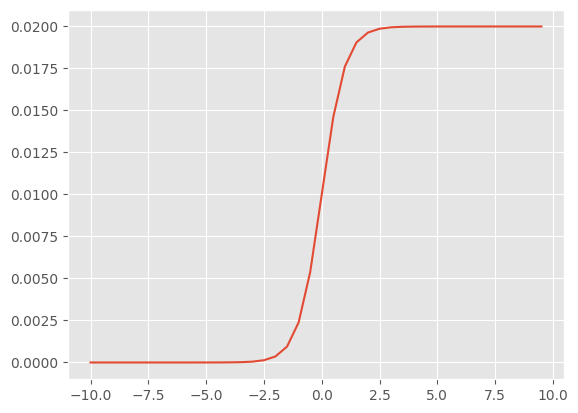

In [39]:
# h , T 固定
# Jを変えてみる
h = 0.01
T = 1
J = np.arange(-10 ,10 ,  0.5)
magnetization_expectation = np.array([test_magnetization_expectation(j , h , T) for j in J])
plt.plot(J , magnetization_expectation)

外部磁場を変えてみる

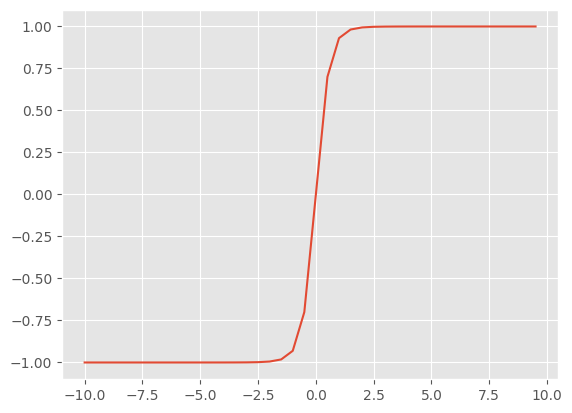

In [40]:
# J , T 固定
# hを変えてみる
J = 1
T = 1
h = np.arange(-10 , 10 , 0.5)
magnetization_expectation = np.array([test_magnetization_expectation(J , hh , T) for hh in h])
plt.plot(h , magnetization_expectation)


### 1次元イジング模型
$L$個の粒子からなる1次元イジング模型を考えます．
$$
E[C] = -J \sum^{L-1}_{i=1} s_i s_{i+1} -h \sum^{L}_{i=1} s_i
$$
平均場近似を用いると相転移の様子がわかる．

具体的には以下の交点が解となる．
$$
y=m\  ,\  y = \tanh(2\beta m +\beta h)
$$

ここでは横軸$m$，縦軸$y$として様々なパラメータの様子をプロットしてみる．

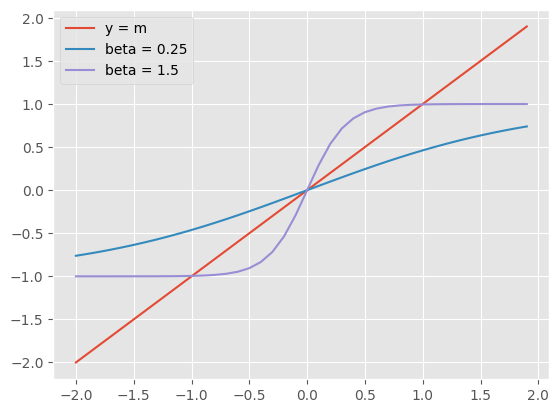

In [41]:
h = 0
beta1 = 0.25
beta2 = 1.5

m = np.arange(-2.0 , 2.0 , 0.1)
y1 = m
y2 = np.tanh(2*beta1 * m)
y3 = np.tanh(2*beta2 * m)

plt.plot(m , y1 , label = "y = m")
plt.plot(m , y2 , label = "beta = 0.25")
plt.plot(m , y3 , label = "beta = 1.5")
plt.legend()

## 2回目(6/14)：『これならわかる機械学習入門』10章

https://www.amazon.co.jp/%E3%81%93%E3%82%8C%E3%81%AA%E3%82%89%E3%82%8F%E3%81%8B%E3%82%8B%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E5%85%A5%E9%96%80-KS%E7%89%A9%E7%90%86%E5%B0%82%E9%96%80%E6%9B%B8-%E5%AF%8C%E8%B0%B7-%E6%98%AD%E5%A4%AB/dp/4065225493

この教科書は，『Machine learning phases of matter』の前半部分を理解するために機械学習の入門的な内容を優しく扱った本です．

まずはこの本の実装を忠実に再現し，論文理解への橋渡しをします．


## MCMC法
### MH法
https://www.youtube.com/watch?v=enOkESSLkf8&t=70s

## ギブスサンプリング（熱浴法）

GitHubコードをそのまま実行してみましょう．

  0%|          | 0/1000 [00:00<?, ?it/s]

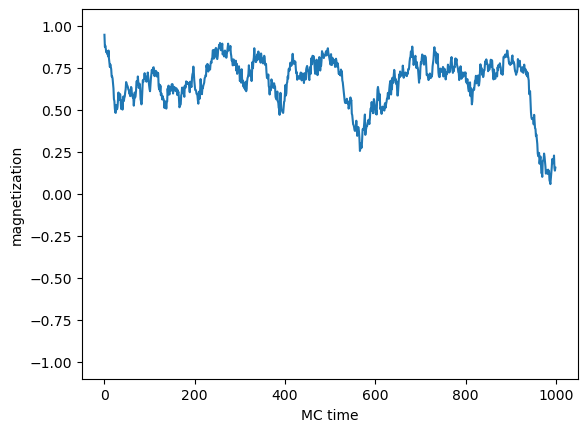

beta=0.9 1100


  0%|          | 0/1100 [00:00<?, ?it/s]


beta=0.85 1100


  0%|          | 0/1100 [00:00<?, ?it/s]


beta=0.8 1100


  0%|          | 0/1100 [00:00<?, ?it/s]


beta=0.7 1100


  0%|          | 0/1100 [00:00<?, ?it/s]


beta=0.65 1100


  0%|          | 0/1100 [00:00<?, ?it/s]


beta=0.6 1100


  0%|          | 0/1100 [00:00<?, ?it/s]


beta=0.55 1100


  0%|          | 0/1100 [00:00<?, ?it/s]


beta=0.5 1100


  0%|          | 0/1100 [00:00<?, ?it/s]


beta=0.47 1100


  0%|          | 0/1100 [00:00<?, ?it/s]


beta=0.42 1100


  0%|          | 0/1100 [00:00<?, ?it/s]


beta=0.4 1100


  0%|          | 0/1100 [00:00<?, ?it/s]


beta=0.35 1100


  0%|          | 0/1100 [00:00<?, ?it/s]


beta=0.3 1100


  0%|          | 0/1100 [00:00<?, ?it/s]


beta=0.25 1100


  0%|          | 0/1100 [00:00<?, ?it/s]


beta=0.2 1100


  0%|          | 0/1100 [00:00<?, ?it/s]


beta=0.15 1100


  0%|          | 0/1100 [00:00<?, ?it/s]


beta=0.1 1100


  0%|          | 0/1100 [00:00<?, ?it/s]


beta=0.05 1100


  0%|          | 0/1100 [00:00<?, ?it/s]


beta=0.0 1100


  0%|          | 0/1100 [00:00<?, ?it/s]

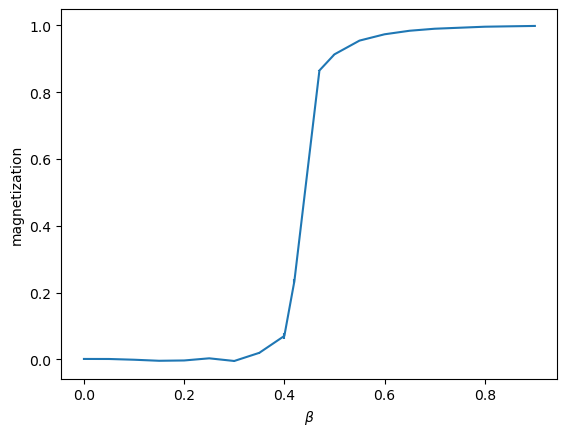

In [34]:
# 2d Ising model
import math
import random
import matplotlib.pyplot as plt
import numpy as np
# tqdm はプログレスバーを表示するためのライブラリ
from tqdm. notebook import tqdm

# 周期的境界条件を考慮してサイトの移動を管理
def xup(x):
  x+=1
  if x>=L[0]:
    x-=L[0] 
  return x
def yup(y): 
  y+=1
  if y>=L[1]:
    y-=L[1] 
  return y
def xdn(x):
  x-=1
  if x<0:
    x+=L[0]
  return x
def ydn(y):
  y-=1
  if y<0:
    y+=L[1]
  return y

# ある点 (x,y)の上下左右のスピンを合計する
def spin_sum(sc,x,y):
  h=0
  h+=sc[xup(x)][y]
  h+=sc[xdn(x)][y]
  h+=sc[x][yup(y)]
  h+=sc[x][ydn(y)]
  return h

# ある点 (x,y)の熱浴法を行う
def heatbath_local(beta,hz,sc,x,y):
  h = spin_sum(sc,x,y)-hz
  # このサイトが次に s=+1 となる確率を計算する 
  p = math.exp(beta*h)/(math.exp(beta*h) + math.exp(-beta*h))
  r = random.random()
  # 確率に基づいてランダムにs を決定する 
  if r < p: # success
    sc[x][y]=1
  else:
    sc[x][y]=-1
  return sc

# すべての (x,y)に対して熱浴法を行う 
def heatbath(beta,hz,sc):
  xlist = list(range(L[0]) ) 
  random.shuffle(xlist) 
  ylist = list(range(L[1]) ) 
  random.shuffle(ylist) 
  for x in xlist:
    for y in ylist:
      sc = heatbath_local(beta,hz,sc,x,y)
  return sc

# 磁化率を計算する
def magnetization (sc):
  m=0
  for x in range(L[0]):
    for y in range(L[1]):
      m+=sc[x][y]
  return m/(L[0]*L[1])

# モンテカルロ法の初期配位をセットする 
def init_conf_cold():
  sc = [[1]*L[1] for i in range(L[0])]
  return sc

def init_conf(init="cold"):
  sc = init_conf_cold()
  if init=="cold":
    return sc
  for x in range(L[0]): 
    for y in range(L[1]): 
      r = random.random() 
      if r<0.5:
        sc[x][y]=1
      else:
        sc[x][y]=-1
  return sc


L = [32,32]
beta = 0.440687 
hz=0.0
Nsweep = 10**3
#
sc = init_conf()
mctime=[];mag_hist=[]
for isweep in tqdm(range(Nsweep)):
  sc = heatbath(beta,hz,sc)
  mag=magnetization(sc)
  mctime.append(isweep)
  mag_hist.append(mag)
plt.plot(mctime,mag_hist)
plt.ylim([-1.1,1.1])
plt.xlabel("MC time")
plt.ylabel("magnetization")
plt.show()



# conf ディレクトリがなければ作る
import os
os.makedirs("conf", exist_ok = True)
#
L = [32,32] # 格子サイズの設定
hz = -0.0005 # 相転移を見るために非常に弱い磁場を添加

nprm=len(prm_list) # パラメータリストの長さを調べる
betas = []
mags = []
mags_er = []
#
random.seed(12345)
sc = init_conf()
# 各ベータごとにパラメータを読み出して配位を作る
for ibeta in range(nprm):
  beta = prm_list[ibeta][0]
  Nsweep = prm_list[ibeta][1]
  Ndiscard = prm_list[ibeta][2]
  fname = prm_list[ibeta][3]
  save_every = prm_list[ibeta][4]
  conf_cnt = 0
#
  print(f"beta={beta} {Nsweep}")
  mag_hist=[]
  # 熱浴法で配位を作る
  for isweep in tqdm(range(Nsweep)):
    sc = heatbath(beta,hz,sc)
    mag=magnetization(sc)
    mag_hist.append(mag)
    if (isweep%save_every == 0)&(isweep>=Ndiscard):
      scn = np.array(sc)
      np.save(f"{fname}{conf_cnt}",scn)
      conf_cnt+=1
  #
  print("")
  mag_hist=np.array(mag_hist[Ndiscard:])
  mag = np.mean(mag_hist)
  mag_er = np.std(mag_hist)/np.sqrt(len(mag_hist)-1) #
  betas.append(beta)
  mags.append(mag)
  mags_er.append(mag_er)
  #
plt.xlabel(r"$\beta$")
plt.ylabel("magnetization")
plt.errorbar(betas,mags,yerr=mags_er)
plt.show()



ここから一つ一つ順を追ってコードを見てみましょう．

### 熱浴法の実装

In [16]:
# 周期的境界条件を考慮してサイトの移動を管理

# 右隣のサイトを返す
def xup(x):
  x+=1
  if x>=L[0]:
    x-=L[0] 
  return x
# 上隣のサイトを返す
def yup(y): 
  y+=1
  if y>=L[1]:
    y-=L[1] 
  return y
# 左隣のサイトを返す
def xdn(x):
  x-=1
  if x<0:
    x+=L[0]
  return x
# 下隣のサイトを返す
def ydn(y):
  y-=1
  if y<0:
    y+=L[1]
  return y

In [23]:
# 挙動の挙動を確認する
L = [4,4] # 4×4の正方格子を作成
'''
[[1]*L[1] for i in range(L[0])] により、長さが L[1] で全ての要素が 1 のリストが L[0] 個生成されます。
すべての正方格子各点が上向きスピンの状態を作成しました．
'''
sc = [[1]*L[1] for i in range(L[0])] # 内包表記で作成
print(sc)


[[1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1]]


In [22]:
sc[0][0]

1

In [20]:
xup(sc[0][0])

2

In [24]:
# ある点 (x,y)の上下左右のスピンを合計する
def spin_sum(sc,x,y):
  h=0
  h+=sc[xup(x)][y]
  h+=sc[xdn(x)][y]
  h+=sc[x][yup(y)]
  h+=sc[x][ydn(y)]
  return h

In [25]:
# 挙動を確認
L = [4,4]
sc = [[1]*L[1] for i in range(L[0])]
print(sc)
print(spin_sum(sc,0,0))

[[1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1]]
4
4
4
4


In [29]:
# ある点 (x,y)の熱浴法を行う
'''
新しいスピンの状態は、近傍のスピンの和と逆温度 beta に依存します。
'''
def heatbath_local(beta,hz,sc,x,y):
  h = spin_sum(sc,x,y)-hz
  # このサイトが次に s=+1 となる確率を計算する 
  p = math.exp(beta*h)/(math.exp(beta*h) + math.exp(-beta*h))
  r = random.random()
  # 確率に基づいてランダムにs を決定する 
  if r < p: # success
    sc[x][y]=1
  else:
    sc[x][y]=-1
  return sc

In [30]:
# 挙動を確認
L = [4,4]
sc = [[1]*L[1] for i in range(L[0])]
print(sc)
print(spin_sum(sc,0,0))
sc = heatbath_local(beta,hz,sc,0,0)
print(sc)

[[1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1]]
4
[[-1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1]]


In [31]:
# 磁化率を計算する
def magnetization (sc):
  m=0
  for x in range(L[0]):
    for y in range(L[1]):
      m+=sc[x][y]
  return m/(L[0]*L[1])



In [35]:
# 挙動の確認
L = [4,4]
sc = [[1]*L[1] for i in range(L[0])]
sc = heatbath_local(beta,hz,sc,0,0)
print(sc)
print(magnetization(sc))

[[-1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1]]
0.875


In [32]:
# モンテカルロ法の初期配位をセットする 
def init_conf_cold():
  sc = [[1]*L[1] for i in range(L[0])]
  return sc

def init_conf(init="cold"):
  sc = init_conf_cold()
  if init=="cold":
    return sc
  for x in range(L[0]): 
    for y in range(L[1]): 
      r = random.random() 
      if r<0.5:
        sc[x][y]=1
      else:
        sc[x][y]=-1
  return sc

  0%|          | 0/1000 [00:00<?, ?it/s]

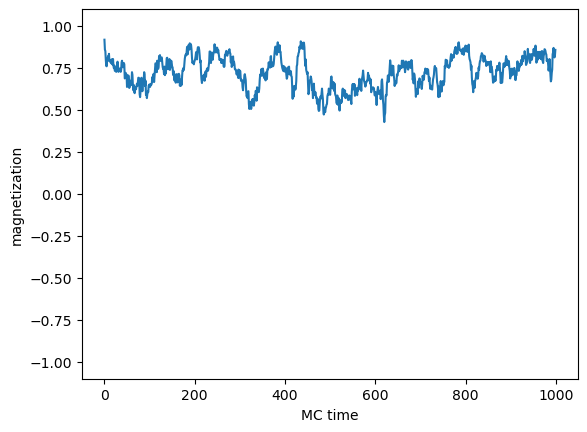

In [39]:
# モンテカルロシミュレーション開始
'''
32×32 の正方格子を作成し、磁場をかけて熱浴法を行う。
ただし外部磁場はかけない。
逆温度は 0.440687 とする。つまり，T=2.269 Kに対応する。
'''
L = [32,32]
beta = 0.440687 
hz=0.0
Nsweep = 10**3
#
sc = init_conf()
mctime=[];mag_hist=[]
for isweep in tqdm(range(Nsweep)):
  sc = heatbath(beta,hz,sc)
  mag=magnetization(sc)
  mctime.append(isweep)
  mag_hist.append(mag)
plt.plot(mctime,mag_hist)
plt.ylim([-1.1,1.1])
plt.xlabel("MC time")
plt.ylabel("magnetization")
plt.show()

磁化率がの推移がわかります．

## 3回目(6/21):『これならわかる機械学習入門』11章